<a href="https://colab.research.google.com/github/Loop3D/Kalgoorlie_fault_network/blob/main/report_files/05_Kanowna%20Fault.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
if 'google.colab' in str(get_ipython()):
      !git clone https://github.com/Loop3D/Kalgoorlie_fault_network.git
      %cd Kalgoorlie_fault_network/report_files_faults
      !pip install git+https://github.com/Loop3D/LoopProjectFile.git
      !pip install git+https://github.com/Loop3D/map2loop-2.git
      !pip install git+https://github.com/Loop3D/LoopStructural
      !pip install lavavu-osmesa geopandas meshio rasterio owslib

else:
      print('Not running on CoLab, nothing to do')

Not running on CoLab, nothing to do


In [6]:
#downloads the dem as a tif file from the WCS server

from owslib.wcs import WebCoverageService as w

wcs = w(url="http://services.ga.gov.au/site_9/services/DEM_SRTM_1Second_over_Bathymetry_Topography/MapServer/WCSServer?", 
        version = "1.0.0")

test = wcs.getCoverage(identifier = "1", bbox = (214793, 6501886, 400412, 6653022), 
                      format="GeoTIFF", crs = 28351, width=200, height=200)

file = open("./data/dem.tif", 'wb')
file.write(test.read())
file.close()

# Imports

In [7]:
import geopandas as gpd
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer
from LoopStructural.modelling import ProcessInputData
from LoopStructural.utils import dtm_creator

path_seismic = r"./data/seismic"
path_shp = r"./data/gis"
path_DEM =  r"./data/DEM.tif"

In [8]:
# a function to darken the color of a hex list

def darken_color(color, amount=1.5):

    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [9]:
updated_data = pd.read_csv("./data/LoopStructural_data/updated_data.csv")
updated_oris = pd.read_csv("./data/LoopStructural_data/updated_oris.csv")

# Add data

In [10]:
Kanowna_pts = gpd.read_file(os.path.join(path_shp, "Kanowna_pts_elevation.shp"))
Kanowna_pts = pd.DataFrame({'X': Kanowna_pts.geometry.x, 
              'Y': Kanowna_pts.geometry.y, 
              'Z': Kanowna_pts.DEM_main})

Kanowna_pts['fault_name'] = "Kanowna Fault"

Kanowna_seismic = gpd.read_file(os.path.join(path_seismic, "Kanowna_fault.shp"))

Kanowna_seismic = Kanowna_seismic[['X', 'Y', 'depth_minu', 'FAULT']]
Kanowna_seismic.columns = ['X', 'Y', 'Z', 'fault_name']

Kanowna_seismic['fault_name'] = Kanowna_seismic['fault_name'].str.replace('Kanowna', "Kanowna Fault")

In [11]:
gs = []

tmpA = []
tmpB = []

xs = Kanowna_seismic['X'].to_numpy()
ys = Kanowna_seismic['Y'].to_numpy()
zs = Kanowna_seismic['Z'].to_numpy()

meanX = Kanowna_pts['X'].mean()
meanY = Kanowna_pts['Y'].mean()
meanZ = zs.mean()

for j in range(len(xs)):
    tmpA.append([xs[j], ys[j], 1])
    tmpB.append(zs[j])

b = np.matrix(tmpB).T
A = np.matrix(tmpA)

fit = (A.T * A).I * A.T * b

# find the norms
kdr1 = pd.DataFrame({'gx': [fit[0,0]], 
                  'gy': fit[1,0], 
                  'gz': -1})

kdr1 /= np.linalg.norm(kdr1)

gs.append(['Kanowna Fault', meanX, meanY, meanZ, 
           kdr1['gx'][0], 
           kdr1['gy'][0],
           kdr1['gz'][0]])

In [12]:
ori = pd.DataFrame(gs, columns = ['fault_name', 'X', 'Y', 'Z', 'gx', 'gy', 'gz'])
updated_ori = pd.concat([updated_oris, ori])

In [13]:
updated_data = pd.concat([updated_data, Kanowna_seismic, Kanowna_pts])

In [14]:
origin = [214794.5029269870719872, 6501887.2589999996125698, -40000]
maximum = [400411.4882275541312993, 6653021.2462467299774289, 5000]

In [15]:
processor = ProcessInputData(fault_locations = updated_data, fault_orientations = updated_ori,
                             origin=origin, maximum=maximum)

model = GeologicalModel(origin, maximum)

model.data = processor.data
model.nsteps = [100, 100, 250]

##########################################
####### Faults from previous work ########
##########################################
model.create_and_add_fault('Ida Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                          npw=5, cpw = 0.05)

model.create_and_add_fault('Kunanalling Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                          npw = 5, cpw = 0.05)

model.create_and_add_fault('Bulla_Abut_South', displacement = 5, nelements=1e4)
model.create_and_add_fault('Bulla_Abut_North', displacement = 5, nelements=1e4)
model.create_and_add_fault('Bullabulling South Fault', displacement = 5, nelements=1e4, cpw = 0.2)
model.create_and_add_fault('Bullabulling North Fault', displacement = 5, nelements=1e4, cpw = 0.2)
model.create_and_add_fault('Zuleika Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cpw = .05)
model.create_and_add_fault('MtMonger Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cwp = 0.2)

# Force the tangents on Bullabulling Fault
tang2 = np.tile([-30838.81,  -3624.64,  12250.14],
                (model['Bullabulling North Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Bullabulling North Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Bullabulling North Fault'][0].interpolator.support.barycentre,
                vector = tang2, w=1, B=0)

tang3 = np.tile([-30838.81,  -3624.64,  12250.14],
                (model['Bullabulling South Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Bullabulling South Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Bullabulling South Fault'][0].interpolator.support.barycentre,
                vector = tang3, w=1, B=0)

# add abutting relationships
model['Kunanalling Fault'].add_abutting_fault(model['Ida Fault'])
model['Bullabulling North Fault'].add_abutting_fault(model['Bulla_Abut_North'])
model['Bullabulling South Fault'].add_abutting_fault(model['Bulla_Abut_South'])
model['Bulla_Abut_South'].add_abutting_fault(model['Ida Fault'])
model['Bullabulling North Fault'].add_abutting_fault(model['Kunanalling Fault'])
model['Bulla_Abut_North'].add_abutting_fault(model['Ida Fault'])
model['Zuleika Fault'].add_abutting_fault(model['Kunanalling Fault'])


##########################################
########### NEW: Kanowna fault ##########
##########################################

model.create_and_add_fault('Kanowna Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, npw = 10, cpw = 0.2)
model['Kanowna Fault'].add_abutting_fault(model['MtMonger Fault'])

model.update(verbose = True)

C:\Users\angel\anaconda3\envs\new_loop\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


Updating geological model. There are: 
 27                     geological features that need to be interpolated



  0%|          | 0/27 [00:00<?, ?it/s]

Model update took: 175.61290669441223 seconds



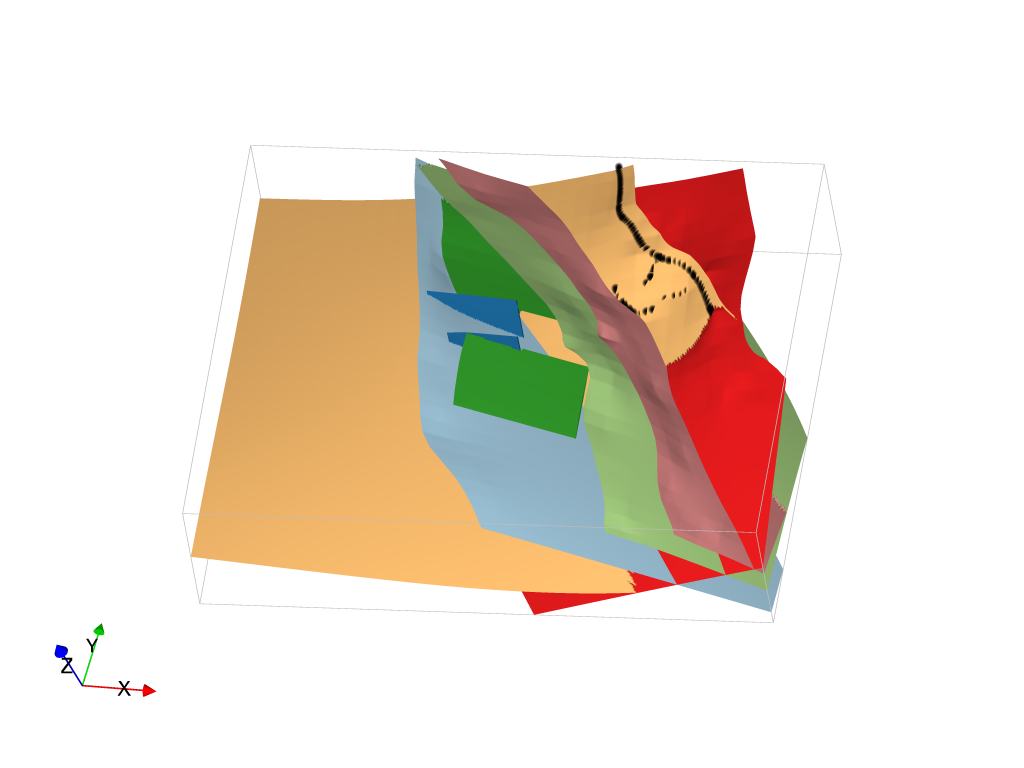

In [16]:
view = LavaVuModelViewer(model)

color_list = ['#a6cee3', '#b2df8a', '#1f78b4', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00']

view.nelements = 1e7

view.add_isosurface(model['Ida Fault'], colours = ['#a6cee3'], value = 0)
view.add_isosurface(model['Kunanalling Fault'], colours = ['#b2df8a'], value = 0)

view.add_isosurface(model['Bulla_Abut_South'], colours = ['#1f78b4'], value = 0)
view.add_isosurface(model['Bulla_Abut_North'], colours = ['#1f78b4'], value = 0)

view.add_isosurface(model['Bullabulling South Fault'], colours = ['#33a02c'], value = 0)
view.add_isosurface(model['Bullabulling North Fault'], colours = ['#33a02c'], value = 0)

view.add_isosurface(model['Zuleika Fault'], colours = ['#fb9a99'], value = 0)
view.add_isosurface(model['MtMonger Fault'], colours = ['#e31a1c'], value = 0)

view.add_isosurface(model['Kanowna Fault'], colours = ['#fdbf6f'], value = 0)

    
view.add_points(Kanowna_seismic[['X', 'Y', 'Z']], name = "Kanowna seismic", pointsize = 10, colour = "black")    
view.add_points(Kanowna_pts[['X', 'Y', 'Z']], name = "Kanowna surface", pointsize = 10, colour = "black")

view.zmax = 0.95
# view.interactive()

view.rotation = [-39.2651481628418, -10.62525749206543, -1.8988970518112183]
view.display()

In [17]:
updated_data.reset_index(drop=True).to_csv("./data/LoopStructural_data/updated_data.csv", index=False)
updated_ori.reset_index(drop=True).to_csv("./data/LoopStructural_data/updated_oris.csv", index=False)